In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

# Load the dataset
df_raw = pd.read_csv('../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Convert 'is_holiday' from categorical to binary (1 for any holiday, 0 for non-holiday)
#df_raw['is_holiday'] = df_raw['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Numerical features
#X_numerical = df.drop(['date_time', 'is_holiday', 'weather_type', 'weather_description', 'traffic_volume'], axis=1)

# Categorical features
#X_categorical = df[['is_holiday', 'weather_type', 'weather_description']]

# Scale the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Split the data into train and test sets
total_samples = df.shape[0]
split_index = int(total_samples * 0.9)

X_train = df[:split_index]
y_train = y.iloc[:split_index]
X_test = df[split_index:]
y_test = y.iloc[split_index:]

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the GridSearchCV object with the time series cross-validator
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1
)

# Fit the grid search to the scaled data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters_grid = grid_search.best_params_
print(f"Best parameters found with GridSearchCV: {best_parameters_grid}")

# Train the best model on the scaled data
best_model_grid = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model_grid, 'best_xgboost_model_gridsearch.joblib')

# Evaluate metrics on the training set
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid)
}

# Evaluate metrics on the validation set
y_val_pred_grid = best_model_grid.predict(X_test)
val_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred_grid)),
    'MSE': mean_squared_error(y_test, y_val_pred_grid),
    'MAE': mean_absolute_error(y_test, y_val_pred_grid),
    'MAPE': mape_scorer(y_test, y_val_pred_grid)
}

# Print and compare metrics for GridSearchCV
print("\nMetrics with GridSearchCV:")
print("Training Set Metrics:")
print(train_metrics_grid)
print("\nValidation Set Metrics:")
print(val_metrics_grid)


Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best parameters found with GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 10, 'subsample': 1.0}

Metrics with GridSearchCV:
Training Set Metrics:
{'RMSE': 9.315502464737913, 'MSE': 86.77858617053813, 'MAE': 6.665259005833281, 'MAPE': 1.1872418192004621}

Validation Set Metrics:
{'RMSE': 11.741891795265847, 'MSE': 137.8720229317314, 'MAE': 7.148150499131944, 'MAPE': 0.3444963397258726}


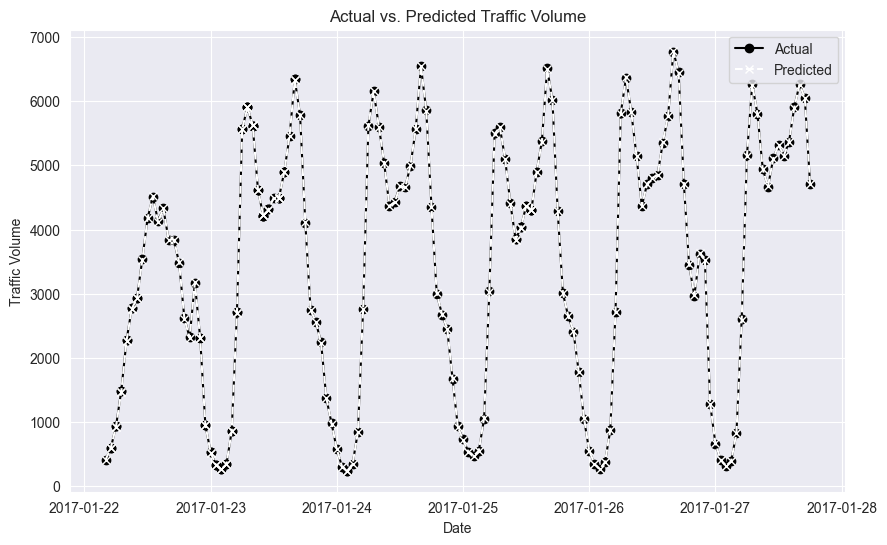

In [2]:
# Plot the first unseen 7 days of validation/test data
unseen_days = 168

# Create a DataFrame with the date_time index for plotting
plot_df = pd.DataFrame(index=y_test.index[:unseen_days])

# Add the actual traffic volume
plot_df['Actual'] = y_test[:unseen_days].values

# Predict traffic volume using the best model
plot_df['Predicted'] = best_model_grid.predict(X_test.iloc[:unseen_days, :])

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='white')
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

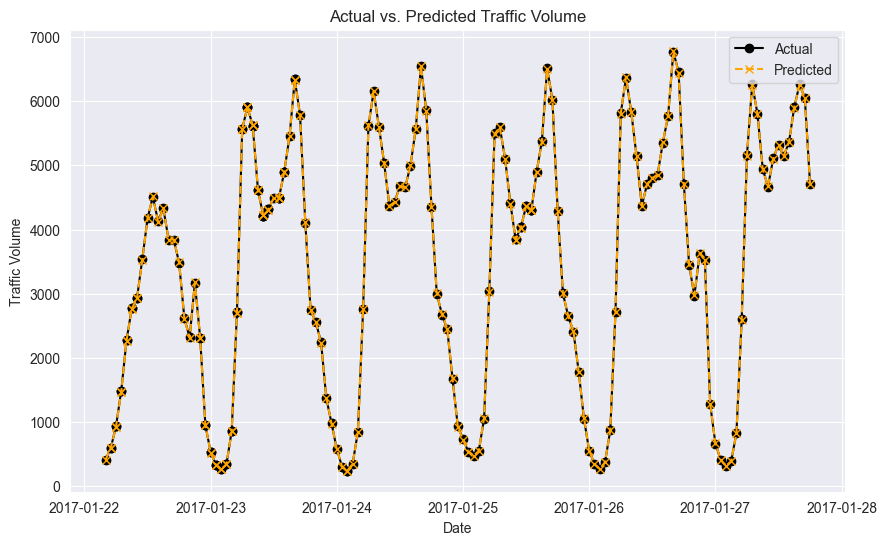

In [3]:
# Plot the first unseen 7 days of validation/test data
unseen_days = 168

# Create a DataFrame with the date_time index for plotting
plot_df = pd.DataFrame(index=y_test.index[:unseen_days])

# Add the actual traffic volume
plot_df['Actual'] = y_test[:unseen_days].values

# Predict traffic volume using the best model
plot_df['Predicted'] = best_model_grid.predict(X_test.iloc[:unseen_days, :])

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [ ]:
# Assuming existing setup as per your provided code

# Define the number of future steps to predict
num_future_steps = 24

for step in range(num_future_steps):
    # Prepare the input for the next prediction
    X_next = prepare_input(df, step)  # Implement this function to create the input using the latest data

    # Make a prediction
    y_pred_next = best_model_grid.predict(X_next)

    # Update the dataset with the new prediction
    df = update_dataset(df, y_pred_next)  # Implement this function to update the dataset

    # Decide when to retrain the model
    if should_retrain(step):  # Implement this logic
        X_train, y_train = get_training_data(df)  # Implement this function to get updated training data
        best_model_grid.fit(X_train, y_train)
        # Optionally save the retrained model
        joblib.dump(best_model_grid, 'best_xgboost_model_updated.joblib')
